<a href="https://colab.research.google.com/github/gabrieldimas/panaromic-photo-caries-detection-using-cnn/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/data/dataset/cut/training'
test_dir = '/content/drive/MyDrive/data/dataset/cut/testing'

In [6]:
# Count the number of images in each class
train_caries_count = len(os.listdir(os.path.join(train_dir, 'caries')))
train_no_caries_count = len(os.listdir(os.path.join(train_dir, 'non-caries')))
test_caries_count = len(os.listdir(os.path.join(test_dir, 'caries')))
test_no_caries_count = len(os.listdir(os.path.join(test_dir, 'non-caries')))

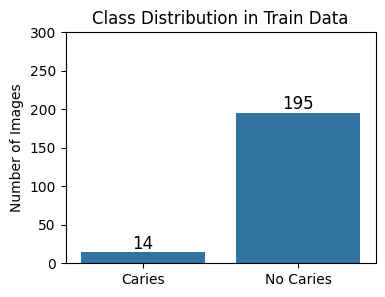

In [7]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[train_caries_count, train_no_caries_count])
plt.title('Class Distribution in Train Data')
plt.ylabel('Number of Images')
plt.ylim(0, 300)

# Add data labels to the bars
for i, count in enumerate([train_caries_count, train_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

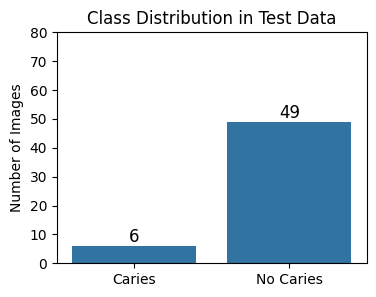

In [10]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[test_caries_count, test_no_caries_count])
plt.title('Class Distribution in Test Data')
plt.ylabel('Number of Images')
plt.ylim(0, 80)

# Add data labels to the bars
for i, count in enumerate([test_caries_count, test_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

(array([  35139.,   26373.,   38694.,   57579.,   80181.,  109317.,
         154983.,  224418.,  284628.,  342879.,  476238.,  449688.,
         494163.,  544836.,  603642.,  672117.,  747330.,  815388.,
         904050.,  987477., 1297995., 1177653., 1241556., 1320774.,
        1361460., 1421007., 1405050., 1404666., 1322490., 1217061.,
        1319193.,  987945.,  871257.,  769956.,  661848.,  572610.,
         493182.,  413526.,  341397.,  275493.,  256257.,  167304.,
         142677.,  124377.,  114765.,  111255.,  127098.,  150387.,
         147387.,   86214.]),
 array([  0.        ,   5.0999999 ,  10.19999981,  15.30000019,
         20.39999962,  25.5       ,  30.60000038,  35.70000076,
         40.79999924,  45.90000153,  51.        ,  56.09999847,
         61.20000076,  66.30000305,  71.40000153,  76.5       ,
         81.59999847,  86.69999695,  91.80000305,  96.90000153,
        102.        , 107.09999847, 112.19999695, 117.30000305,
        122.40000153, 127.5       , 132.60

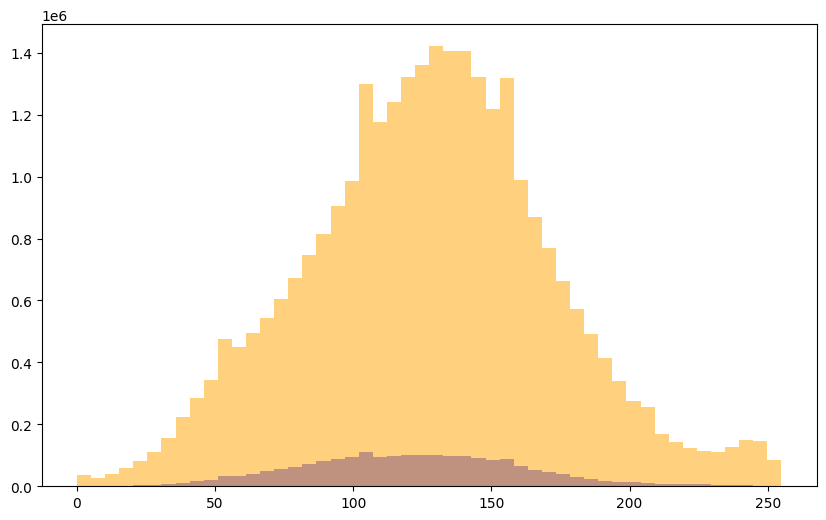

In [12]:
# Define the target image size
target_size = (224, 224)

# Load caries images as a NumPy array
caries_image_paths = [os.path.join(train_dir, 'caries', filename) for filename in os.listdir(os.path.join(train_dir, 'caries'))]
caries_images = []
for img_path in caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    caries_images.append(img_array)
caries_images = np.array(caries_images)

# Load no caries images as a NumPy array
no_caries_image_paths = [os.path.join(train_dir, 'non-caries', filename) for filename in os.listdir(os.path.join(train_dir, 'non-caries'))]
no_caries_images = []
for img_path in no_caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    no_caries_images.append(img_array)
no_caries_images = np.array(no_caries_images)

# Plot histograms of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(caries_images.flatten(), bins=50, color='blue', alpha=0.5, label='Caries')
plt.hist(no_caries_images.flatten(), bins=50, color='orange', alpha=0.5, label='No Caries')

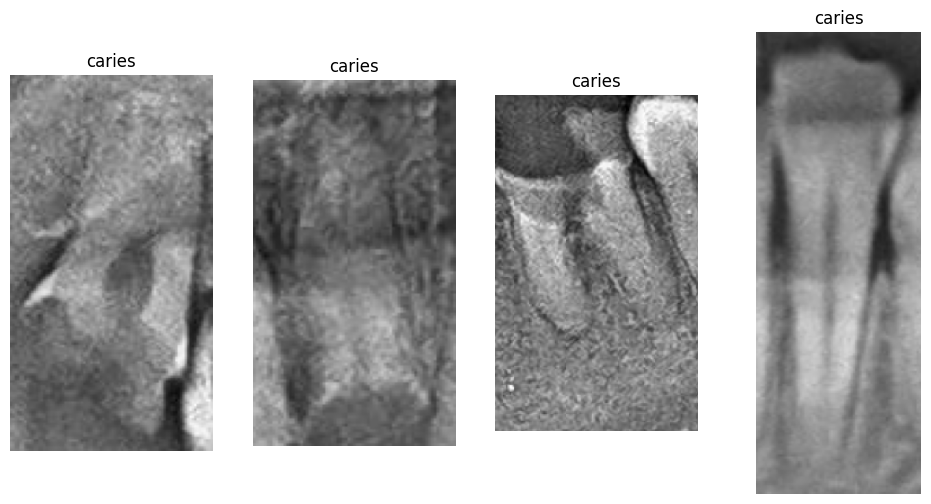

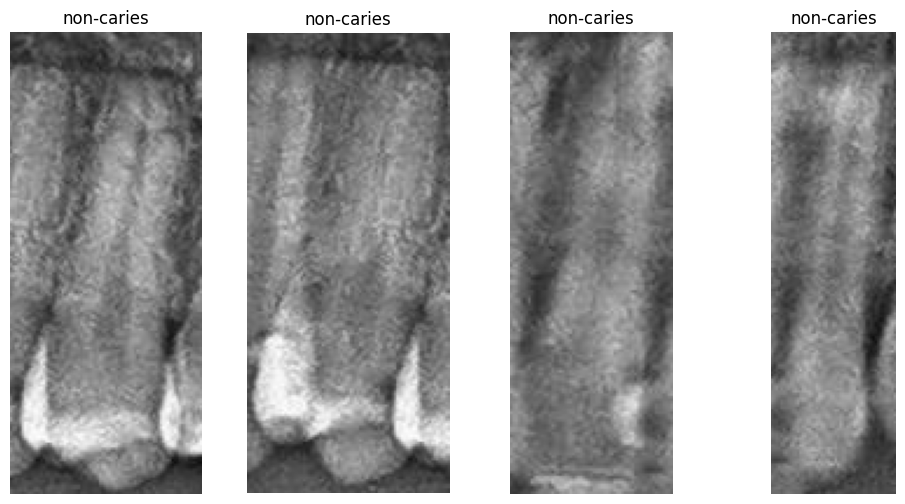

In [13]:
def display_samples(class_name, directory):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        img = Image.open(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_samples('caries', train_dir)
display_samples('non-caries', train_dir)

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 209 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


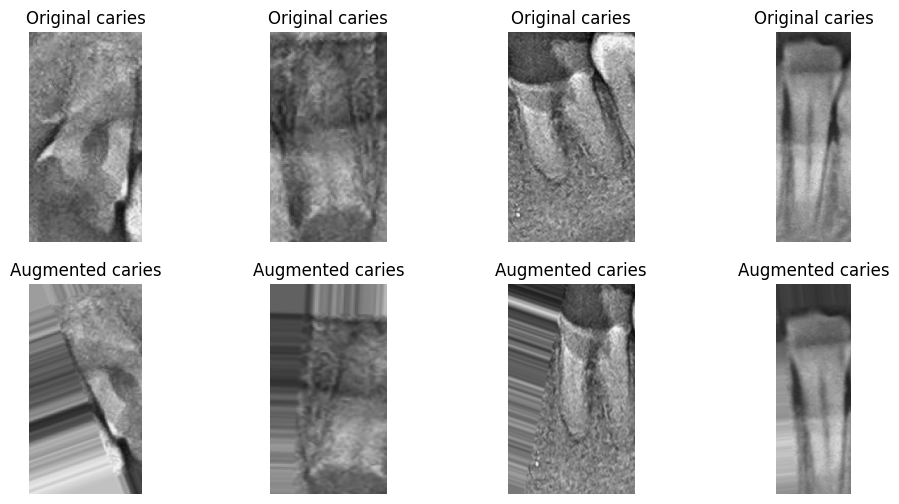

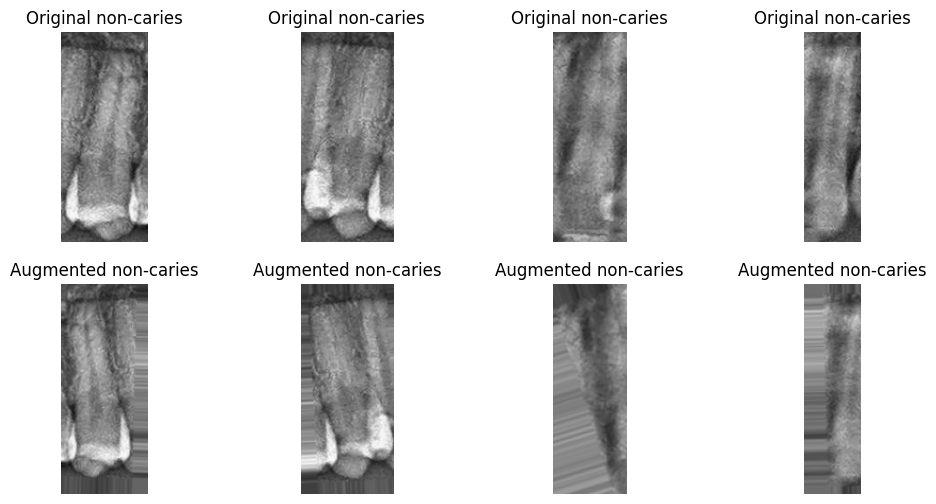

In [34]:
def display_augmented_images(class_name, directory, generator):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        original_image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        original_img = Image.open(original_image_path)

        # Convert PIL Image to NumPy array
        original_array = np.array(original_img)

        # Apply random transformation to the NumPy array
        augmented_array = generator.random_transform(original_array)

        augmented_img = Image.fromarray(augmented_array)

        plt.subplot(2, 4, i + 1)
        plt.imshow(original_img)
        plt.title(f'Original {class_name}')
        plt.axis('off')

        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented_img)
        plt.title(f'Augmented {class_name}')
        plt.axis('off')

    plt.show()

    # Display augmented images for 'caries' class
display_augmented_images('caries', train_dir, train_datagen)

# Display augmented images for 'no_caries' class
display_augmented_images('non-caries', train_dir, train_datagen)

In [35]:
# Model with regularization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
def get_predictions():
    # Get a batch of data from the validation generator
    X_val_batch, y_val_batch = next(test_generator)

    # Get predictions
    y_pred_batch = model.predict(X_val_batch)

    # Convert predictions to binary (0 or 1)
    y_pred_batch_binary = (y_pred_batch > 0.5).astype(int)



In [81]:
for epoch in range(10):  # Adjust to your number of epochs
       history = model.fit(
           train_generator,
           steps_per_epoch=len(test_generator),
           epochs=1,  # Single epoch for each loop iteration
           validation_data=test_generator,
           validation_steps=len(test_generator)
       )
       test_generator.reset() # Reset before the next epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9688 - loss: 0.2518 - val_accuracy: 0.8909 - val_loss: 0.3739
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.9792 - loss: 0.1983 - val_accuracy: 0.8909 - val_loss: 0.3943
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.8854 - loss: 0.4160 - val_accuracy: 0.8909 - val_loss: 0.3984
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9375 - loss: 0.3256 - val_accuracy: 0.8909 - val_loss: 0.3864
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9062 - loss: 0.3785 - val_accuracy: 0.8909 - val_loss: 0.3666
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.9456 - loss: 0.2835 - val_accuracy: 0.8909 - val_loss: 0.3626
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.9792 - loss: 0.1905 - val_accuracy: 0.8909 - val_loss: 0.3736
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9062 - loss: 0.3318 - val_accuracy: 0.8909 - val_loss: 0.3881
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9062 - loss: 0.3778 - val_accuracy: 0.8909 - 

In [72]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step - accuracy: 0.9064 - loss: 0.3982
Test accuracy: 0.89


In [73]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.round(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step


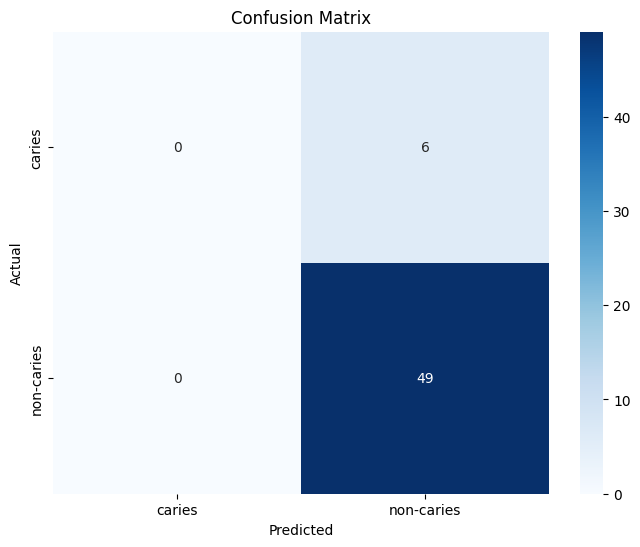

              precision    recall  f1-score   support

      caries       0.00      0.00      0.00         6
  non-caries       0.89      1.00      0.94        49

    accuracy                           0.89        55
   macro avg       0.45      0.50      0.47        55
weighted avg       0.79      0.89      0.84        55



In [74]:
# Suppress UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)

In [77]:
print(history.history)

{'accuracy': [0.953125], 'loss': [0.23691633343696594], 'val_accuracy': [0.8909090757369995], 'val_loss': [0.44852790236473083]}


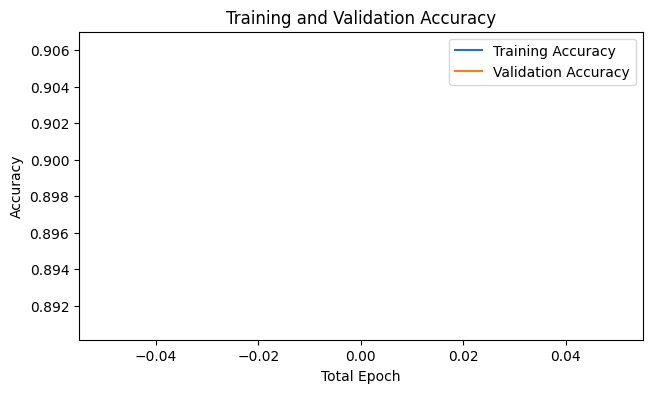

In [82]:
# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))

# Option 1: Plot on the first subplot (adjusting subplot index)
plt.subplot(1, 2, 1)

# Option 2: Remove subplot and plot directly on the figure (preferred)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Total Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()  # Add this line to display the plot

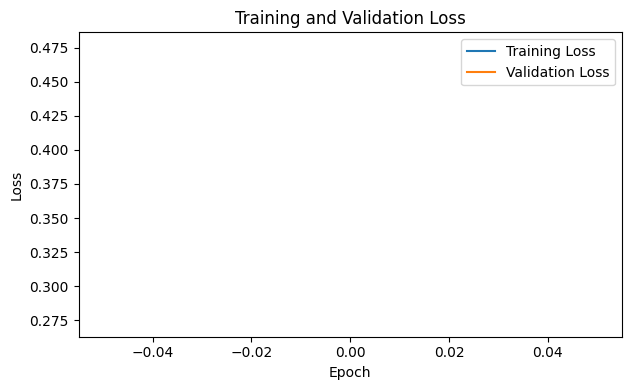

In [57]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


<ipython-input-58-504f6769de6a>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")


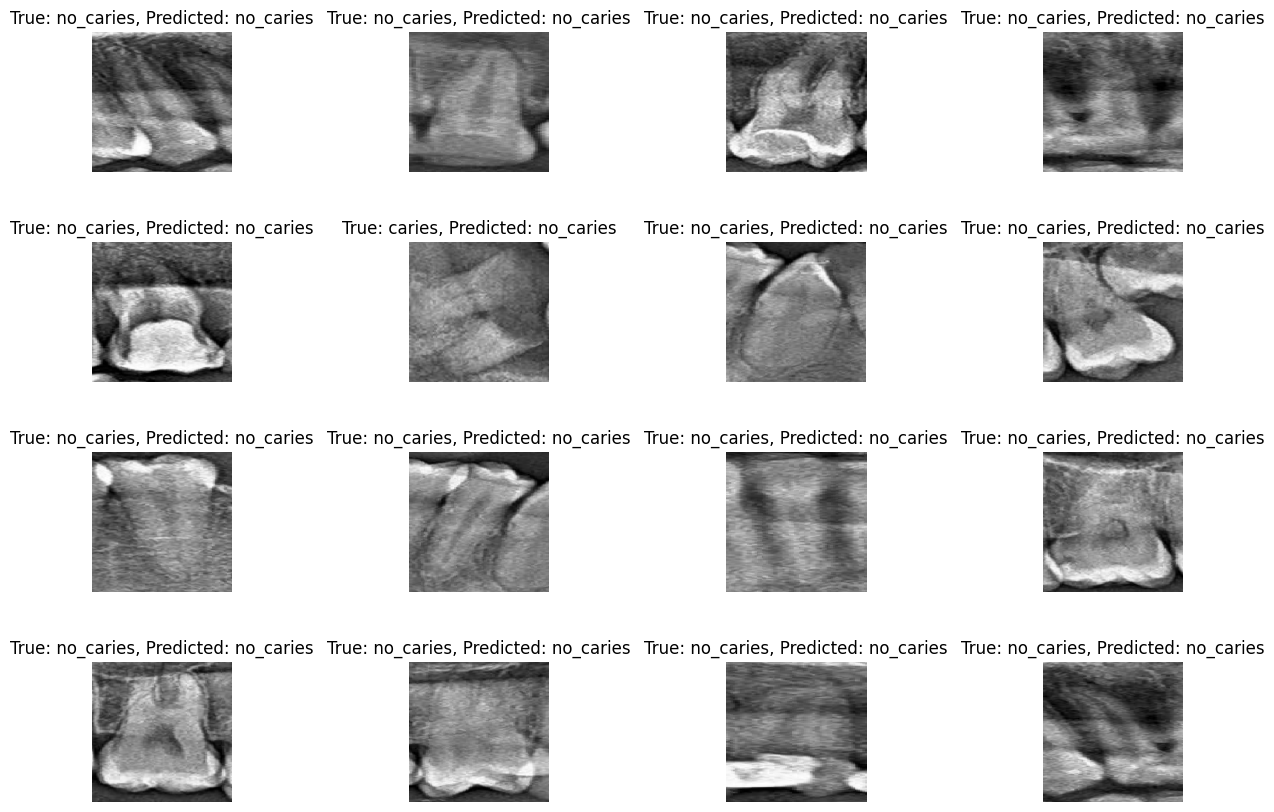

In [58]:
# Load a few test images and predict their labels
num_images_to_predict = 16  # Change this to the number of images you want to predict

# Get a few test images and their true labels
test_images, true_labels = next(test_generator)

# Predict labels for the test images
predicted_labels = model.predict(test_images)

# Convert predicted labels to binary (0 or 1)
predicted_labels = np.round(predicted_labels)

# Define class names
class_names = ['caries', 'no_caries']

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = (num_images_to_predict + num_rows - 1) // num_rows

# Display the test images along with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()